## 任务描述：

### 如何根据据图像的视觉内容为图像赋予一个语义类别是**图像分类**的目标，也是图像检索、图像内容分析和目标识别等问题的基础。

### 实践内容：利用飞桨动态图搭建一个**卷积神经网络**，对包含斑马线的马路和不包含斑马线的马路图像进行分类。

### 特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。

In [ ]:
!pip install PaddlePaddle==2.1.2
print(paddle.__version__)


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
1.8.0


In [ ]:
import os
import zipfile
import random
import json
import paddle
import sys
import numpy as np
from PIL import Image
import paddle.fluid as fluid
import matplotlib.pyplot as plt
print(paddle.__version__)

1.8.0


In [138]:
'''
参数配置
'''
train_parameters = {
    "input_size": [3, 50, 50],                                #输入图片的shape
    "class_dim": -1,                                          #分类数
    "src_path":"data/data17066/Zebra.zip",                    #原始数据集路径
    "target_path":"/home/aistudio/data/",                     #要解压的路径
    "train_list_path": "/home/aistudio/data/train.txt",       #train.txt路径
    "eval_list_path": "/home/aistudio/data/eval.txt",         #eval.txt路径
    "label_dict":{'0':'zebra crossing','1':'others'},         #标签字典
    "num_epochs": 100,                                         #训练轮数
    "train_batch_size": 10,                                   #训练时每个批次的大小
    "learning_strategy": {                                    #优化函数相关的配置
        "lr": 0.5                                           #超参数学习率
    }, 
    'skip_steps': 5,                                         #每N个批次打印一次结果
    'save_steps': 1000,                                         #每N个批次保存一次模型参数
    "checkpoints": "/home/aistudio/work/checkpoints"          #保存的路径

}


# **一、数据准备**

### （1）解压原始数据集

### （2）按照比例划分训练集与验证集

### （3）乱序，生成数据列表

### （4）构造训练数据集提供器和验证数据集提供器

In [ ]:

#解压原始数据集
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至target_path目录下
    '''
    if(not os.path.isdir(target_path + "zebra crossing")):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
        print('数据集解压完成')
    else:
        print('文件已存在')

In [ ]:

def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    data_list_path_1=target_path+"zebra crossing/"
    data_list_path_2=target_path+"others/"
    class_dirs = os.listdir(data_list_path_1)
    all_data_list = []

    for im in os.listdir(data_list_path_1):
        img_path = target_path+"zebra crossing/" + im
        all_data_list.append(img_path + '\t' + '0'+'\n')
 
    for im in os.listdir(data_list_path_2):
        img_path = target_path+"others/" + im
        all_data_list.append(img_path + '\t' + '1' + '\n')

    #对列表进行乱序
    random.shuffle(all_data_list)

    with open(train_list_path, 'a') as f1:
        with open(eval_list_path, 'a') as f2:
            for ind, img_path_label in enumerate(all_data_list):
                #划分测试集和训练集
                if ind % 10 == 0:
                    f2.write(img_path_label) 
                else:
                    f1.write(img_path_label)
    print ('生成数据列表完成！')

In [ ]:

def data_reader(file_list):
    '''
    自定义reader
    '''
    def reader():
        with open(file_list, 'r') as f:
            lines = [line.strip() for line in f]
            for line in lines:
                img_path, lab = line.strip().split('\t')
                img = Image.open(img_path) 
                if img.mode != 'RGB': 
                    img = img.convert('RGB') 
                img = np.array(img).astype('float32') 
                # print(img.shape) 
                img = img.transpose((2, 0, 1))  # HWC to CHW
                # print(img.shape) 
                img = img/255                   # 像素值归一化 
                yield img, int(lab) 
    return reader


In [ ]:

#参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

#解压原始数据到指定路径
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate()     

#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

#构造数据提供器
train_reader = paddle.batch(data_reader(train_list_path),
                            batch_size=batch_size,
                            drop_last=True)                     #若设置为True，则当最后一个batch不等于batch_size时，丢弃最后一个batch；若设置为False，则不会。默认值为False。
eval_reader = paddle.batch(data_reader(eval_list_path),
                            batch_size=batch_size,
                            drop_last=True)


文件已存在
生成数据列表完成！


# **二、模型配置**



In [ ]:
#定义卷积网络
class MyCNN(fluid.dygraph.Layer):
    def __init__(self):
       #===================在这里补充完整代码==================
      super(MyCNN,self).__init__()
      self.conv_1 = fluid.dygraph.Conv2D(num_channels=3, num_filters=32, filter_size=5, stride=1) #通道数、卷积核个数、卷积核大小
      self.pool_1 = fluid.dygraph.Pool2D(pool_size=2, pool_type='max', pool_stride=1)
      self.conv_2 = fluid.dygraph.Conv2D(num_channels=32, num_filters=64, filter_size=3, stride=1)
      self.pool_2 = fluid.dygraph.Pool2D(pool_size=2, pool_type='max', pool_stride=1)
      self.conv_3 = fluid.dygraph.Conv2D(num_channels=64, num_filters=32, filter_size=3, stride=1)
      self.out = fluid.dygraph.Linear(input_dim=32*40*40, output_dim=40, act='softmax')


    #网络的前向计算过程
    def forward(self,input):
      #===================在这里补充完整代码==================
       x = self.conv_1(input)
       x = self.pool_1(x)
       x = self.conv_2(x)
       x = self.pool_2(x)
       x = self.conv_3(x)
       x = fluid.layers.reshape(x, shape=[-1, 32*40*40])
       y = self.out(x)
       return y


# #定义卷积网络
# from paddle.fluid.dygraph import Dropout,Conv2D,Pool2D,Linear
# dropout = Dropout(p=0.5)

# class MyCNN(fluid.dygraph.Layer):
#     def __init__(self):
#       super(MyCNN,self).__init__()
#       self.conv0 = Conv2D(num_channels=3,num_filters=64, filter_size=[3,3] ,stride=1 )
#       self.pool0 = Pool2D(pool_size=2 ,pool_stride =2 )
#       self.conv1 = Conv2D(num_channels=64  ,num_filters=128 ,filter_size=[3,3] ,stride =1  )
#       self.pool1 = Pool2D(pool_size=2 ,pool_stride =2 )
#       self.conv2 = Conv2D(num_channels=128 ,num_filters= 50,filter_size=[2,2])
#       self.pool2 = Pool2D(pool_size=2 ,pool_stride =2 )
#       self.fc1 = Linear(12500,500)
#       self.fc2 = Linear(500,250)
#       self.fc3 = Linear(,40,act='softmax')

#     def forward(self,input):
#       x = self.conv0(input)
#       x = self.pool0(x)
#       x = self.conv1(x)
#       x = self.pool1(x)
#       x = self.conv2(x)
#       x = self.pool2(x)
#       x = paddle.fluid.layers.reshape(x,shape=[-1,12500])
#       x = self.fc1(x)
#       x = self.fc2(x)
#       y = self.fc3(x)     
#       return y

# class MyCNN(fluid.dygraph.Layer):
#     def __init__(self):
#       #===================在这里补充完整代码==================
#       super(MyCNN,self).__init__()
#       self.conv0 = Conv2D(num_channels=3,num_filters=64, filter_size=[3,3] ,stride=1 )
#       self.pool0 = Pool2D(pool_size=2 ,pool_stride =2 )
#       self.conv1 = Conv2D(num_channels=64  ,num_filters=128 ,filter_size=[4,4] ,stride =1  )
#       self.pool1 = Pool2D(pool_size=2 ,pool_stride =2 )
#       self.conv2 = Conv2D(num_channels=128 ,num_filters= 50,filter_size=[5,5])
#       self.pool2 = Pool2D(pool_size=2 ,pool_stride =2 )
#       self.fc1 = Linear(14400,2500)
#       self.fc2 = Linear(2500,250)
#       self.fc3 = Linear(250,32)

      
#     #网络的前向计算过程
#     def forward(self,input):
#       #===================在这里补充完整代码==================
#       x = self.conv0(input)
#       x = self.pool0(x)
#       x = self.conv1(x)
#       x = self.pool1(x)
#       x = self.conv2(x)
#       x = self.pool2(x)
#       x = paddle.fluid.layers.reshape(x,shape=[-1,14400])
#       x = self.fc1(x)
#       x = self.fc2(x)
#       y = self.fc3(x)     
#       y = fluid.layers.softmax(y) 
    
#       return result

# **三、模型训练 && 四、模型评估**

In [ ]:

def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epo: 0,step: 5, ave loss: 32.000000, ave acc: 0.500000
epo: 0,step: 10, ave loss: 19.200001, ave acc: 0.700000
epo: 0,step: 15, ave loss: 38.400002, ave acc: 0.400000
epo: 0,step: 20, ave loss: 64.000000, ave acc: 0.000000
epo: 0,step: 25, ave loss: 32.000000, ave acc: 0.500000
epo: 0,step: 30, ave loss: 32.000000, ave acc: 0.500000
epo: 0,step: 35, ave loss: 32.000000, ave acc: 0.500000
epo: 1,step: 40, ave loss: 51.200001, ave acc: 0.200000
epo: 1,step: 45, ave loss: 38.400002, ave acc: 0.400000
epo: 1,step: 50, ave loss: 25.600000, ave acc: 0.600000
epo: 1,step: 55, ave loss: 38.400002, ave acc: 0.400000
epo: 1,step: 60, ave loss: 12.800000, ave acc: 0.800000
epo: 1,step: 65, ave loss: 57.600002, ave acc: 0.100000
epo: 1,step: 70, ave loss: 38.400002, ave acc: 0.400000
epo: 1,step: 75, ave loss: 51.200001, ave acc: 0.200000
epo: 2,step: 80, ave loss: 19.200001, ave acc: 0.700000
epo: 2,step: 85, ave loss: 19.200001, ave acc: 0.700000
epo: 2,step: 90, ave loss: 64.000000, ave acc: 0.

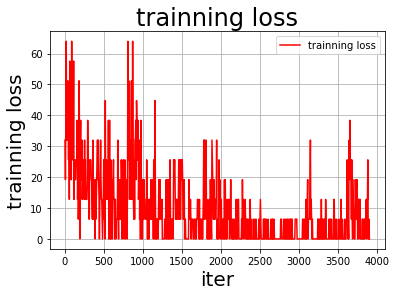

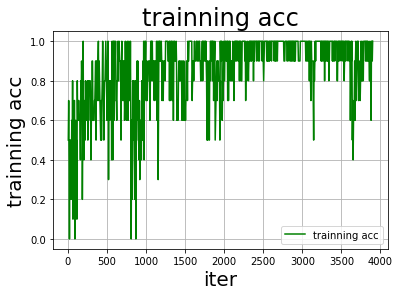

In [139]:
'''
模型训练
'''
place=fluid.CUDAPlace(0) #表示使用GPU进行训练；不设置表示使用CPU进行训练

with fluid.dygraph.guard(place = fluid.CUDAPlace(0)):  
# with fluid.dygraph.guard():  
# with fluid.dygraph.guard():  
    model = MyCNN()
    model.train()
    optimizer=fluid.optimizer.AdamOptimizer(learning_rate=train_parameters['learning_strategy']['lr'],
                                            parameter_list=model.parameters()) 
    steps = 0
    Iters, total_loss, total_acc = [], [], []

    for epo in range(train_parameters['num_epochs']):
        for _, data in enumerate(train_reader()):
            steps += 1
            dy_x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 3, 50, 50)
            y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)

            #将Numpy转换为DyGraph接收的输入
            img = fluid.dygraph.to_variable(dy_x_data)
            label = fluid.dygraph.to_variable(y_data)

            out = model(img)
            #计算精度和损失
            acc=fluid.layers.accuracy(out,label)
            loss = fluid.layers.cross_entropy(out, label)
            avg_loss = fluid.layers.mean(loss)

            #使用backward()方法可以执行反向网络
            avg_loss.backward()
            optimizer.minimize(avg_loss)
             
            #将参数梯度清零以保证下一轮训练的正确性
            model.clear_gradients()
            
            if steps % train_parameters["skip_steps"] == 0:
                Iters.append(steps)
                total_loss.append(avg_loss.numpy()[0])
                total_acc.append(acc.numpy()[0])
                print("epo: %d,step: %d, ave loss: %f, ave acc: %f" %
                     (epo,steps,avg_loss.numpy(),acc.numpy()))
            #保存模型参数
            if steps % train_parameters["save_steps"] == 0:
                save_path = train_parameters["checkpoints"]+"/"+"save_dir_" + str(steps)
                
                print('save model to: ' + save_path)
                fluid.dygraph.save_dygraph(model.state_dict(),
                                           save_path)
    
    fluid.dygraph.save_dygraph(model.state_dict(),train_parameters["checkpoints"] + "/" + "save_dir_final")

    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")


此处遍历了所有保存的模型，选取效果最好的模型作为最终模型。
在共享项目的时候重新运行发现并不是每次都能达到最好的效果，运气好的时候才能有比较好的效果。最佳作业受之有愧，只是运气比较好。

In [140]:
'''
模型校验
'''
import glob
with fluid.dygraph.guard():
    modellist=glob.glob("work/checkpoints/*.pdparams")
    #print(modellist)
    for modelname in modellist:
        model, _ = fluid.load_dygraph(modelname)
        cnn = MyCNN()
        cnn.load_dict(model)
        cnn.eval()
        accs = []
        for batch_id, data in enumerate(eval_reader()):
            
            dy_x_data = np.array([item[0] for item in data], dtype='float32').reshape(-1, 3, 50, 50)
            y_data = np.array([item[1] for item in data], dtype='int64').reshape(-1, 1)
            
            img = fluid.dygraph.to_variable(dy_x_data)
            label = fluid.dygraph.to_variable(y_data)

            out = cnn(img)
            acc=fluid.layers.accuracy(out,label)#计算精度
            lab = np.argsort(out.numpy())
            accs.append(acc.numpy()[0])
        #print(modelname,'模型在验证集上的准确率为：',np.mean(accs))
    print('模型在验证集上的准确率为：',np.mean(accs))

模型在验证集上的准确率为： 0.85


# **五、模型预测**

In [141]:

def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path)
    # print(img.mode)
    if img.mode != 'RGB': 
        img = img.convert('RGB') 
    img = img.resize((50, 50), Image.ANTIALIAS)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                   # 像素值归一化 
    return img

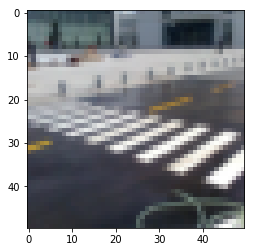

Zebra crossing:1.00, Others:0.00


In [142]:
'''
模型预测
'''
Lab = train_parameters['label_dict']
with fluid.dygraph.guard():
    model, _ = fluid.dygraph.load_dygraph("work/checkpoints/save_dir_final.pdparams")
    cnn = MyCNN()
    cnn.load_dict(model)
    cnn.eval()
    
    #展示预测图片
    infer_path='data/zebra crossing/1.png'
    infer_img = Image.open(infer_path)
    plt.imshow(infer_img)          #根据数组绘制图像
    plt.show()                     #显示图像
    #对预测图片进行预处理
    infer_img = load_image(infer_path)
    infer_img = np.array(infer_img).astype('float32')
    infer_img = infer_img[np.newaxis,:, : ,:] #reshape(-1,3,50,50)
    infer_img = fluid.dygraph.to_variable(infer_img)
    out = cnn(infer_img)
    print("Zebra crossing:{:.2f}, Others:{:.2f}" .format(out.numpy()[0][0],out.numpy()[0][1]))